## Carga de datos

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import os

load_dotenv()

class SQLServerConnection:
    def __init__(self):
        self.server = os.getenv("SQL_SERVER_SERVER")
        self.database = os.getenv("SQL_SERVER_DATABASE")
        self.username = os.getenv("SQL_SERVER_USERNAME")
        self.password = os.getenv("SQL_SERVER_PASSWORD")
        self.port = os.getenv("SQL_SERVER_PORT")

    # f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    def get_connection(self):
        try:          
                    
            trusted_connection = 'yes'  # Utiliza 'yes' para Windows Authentication
            driver = '{SQL Server}'                   
            # Cadena de conexión para Windows Authentication
            # Especificar el controlador de pyodbc en la cadena de conexión
            connection_string = f'mssql+pyodbc://{self.server}/{self.database}?trusted_connection={trusted_connection}&driver=ODBC+Driver+17+for+SQL+Server'

            # connection_string = f'DRIVER={driver};SERVER={self.server};DATABASE={self.database};Trusted_Connection={trusted_connection}'
            engine = create_engine(connection_string)
            return engine
        except Exception as e:
            print(f"Error de conexión: {str(e)}")
            return None
         

#### Query's and dataframes

In [2]:
# Create connection
sql_server_connection = SQLServerConnection()
connection = sql_server_connection.get_connection()

print("connection: ", connection)

# Consulta SQL para extraer datos
sql_query_municipality =  """
SELECT M.code_municipality, M.municipality, M.population,
	   D.code_department, D.name_department,
	   C.code_country, C.name_country
FROM Municipality AS M
JOIN Department AS D ON M.code_department = D.code_department
JOIN Country AS C ON D.code_country = C.code_country;
"""
sql_query_department = 'SELECT * FROM Department'
sql_query_country_cases = 'SELECT * FROM Cases'
sql_query_mdp = """
SELECT
    M.municipality,
    MDR.code_municipality,
    MDR.date_reported,
    MDR.new_deaths,
    SUM(MDR.new_deaths) OVER (PARTITION BY MDR.code_municipality ORDER BY MDR.date_reported) AS cumulative_deaths
FROM
    MunicipalityDeathsReported MDR
JOIN
    Municipality M
        ON M.code_municipality = MDR.code_municipality
ORDER BY
    MDR.code_municipality, MDR.date_reported;
"""
sql_query_mdp_gt_0 = """
SELECT
    M.municipality,
    MDR.code_municipality,
    MDR.date_reported,
    MDR.new_deaths,
    SUM(MDR.new_deaths) OVER (PARTITION BY MDR.code_municipality ORDER BY MDR.date_reported) AS cumulative_deaths
FROM
    MunicipalityDeathsReported MDR
JOIN
    Municipality M
        ON M.code_municipality = MDR.code_municipality
WHERE
    MDR.new_deaths > 0
ORDER BY
    MDR.code_municipality, MDR.date_reported;
"""

# Ejecutar la consulta y cargar los resultados en DataFrames
df_municipality = pd.read_sql(sql_query_municipality, connection)
df_department = pd.read_sql(sql_query_department, connection)
df_country_cases = pd.read_sql(sql_query_country_cases, connection)
df_mdp = pd.read_sql(sql_query_mdp, connection)
df_mdp_gt_0 = pd.read_sql(sql_query_mdp_gt_0, connection)

df_municipality = df_municipality.drop_duplicates()
df_department = df_department.drop_duplicates()
df_country_cases = df_country_cases.drop_duplicates()
df_mdp = df_mdp.drop_duplicates()
df_mdp_gt_0 = df_mdp_gt_0.drop_duplicates()

connection:  Engine(mssql+pyodbc://DESKTOP-4JJFHV8\SQLEXPRESS/ss2?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes)


## EDA Monovariable

### Datos cuantitativos

#### Funcion cuantitativo

In [3]:
def plot_analysis(df, variable_name):
    # Filtra los valores mayores que cero
    filtered_data = df[variable_name][df[variable_name] > 0]

    # Configurar el estilo de seaborn
    sns.set(style="whitegrid")

    # Crear una figura con subgráficos
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Histograma con la transformación logarítmica
    sns.histplot(filtered_data, bins=20, kde=True, edgecolor='black', log_scale=True, ax=axes[0])
    axes[0].set_xlabel(f'Logaritmo de {variable_name}')
    axes[0].set_ylabel('Frecuencia')
    axes[0].set_title(f'Histograma logarítmico de {variable_name}')

    # Diagrama de caja
    sns.boxplot(y=filtered_data, ax=axes[1])
    axes[1].set_ylabel(variable_name)
    axes[1].set_title(f'Diagrama de caja de {variable_name}')

    # Histograma estándar
    sns.histplot(filtered_data, bins=20, kde=True, edgecolor='black', ax=axes[2])
    axes[2].set_xlabel(variable_name)
    axes[2].set_ylabel('Frecuencia')
    axes[2].set_title(f'Histograma estándar de {variable_name}')

    # Estadísticas descriptivas
    statistics = filtered_data.describe()
    statistics_translated = statistics.rename(index={
        'count': 'Conteo',
        'mean': 'Promedio',
        'std': 'Desviación Estándar',
        'min': 'Mínimo',
        '25%': 'Cuartil 25%',
        '50%': 'Mediana',
        '75%': 'Cuartil 75%',
        'max': 'Máximo'
    })

    # Añadir estadísticas traducidas a la tabla
    axes[3].axis('off')
    axes[3].table(cellText=statistics_translated.reset_index().values,
                  colLabels=['Estadísticas', 'Valor'],
                  cellLoc='center', loc='center', colColours=['#f2f2f2']*2)
    axes[3].set_title(f'Estadísticas descriptivas de {variable_name}')

    # Ajustar el diseño
    plt.tight_layout()
    plt.show()

#### Graficos monovariables cuantitativos

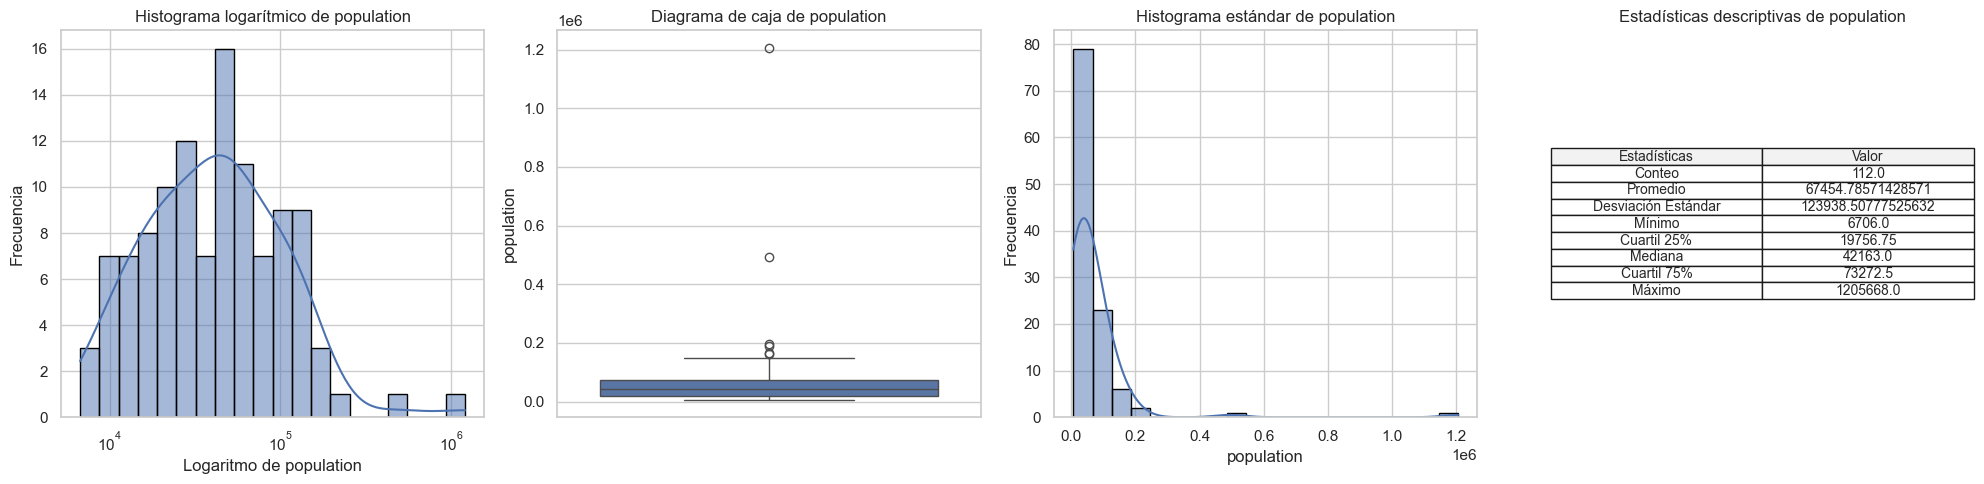

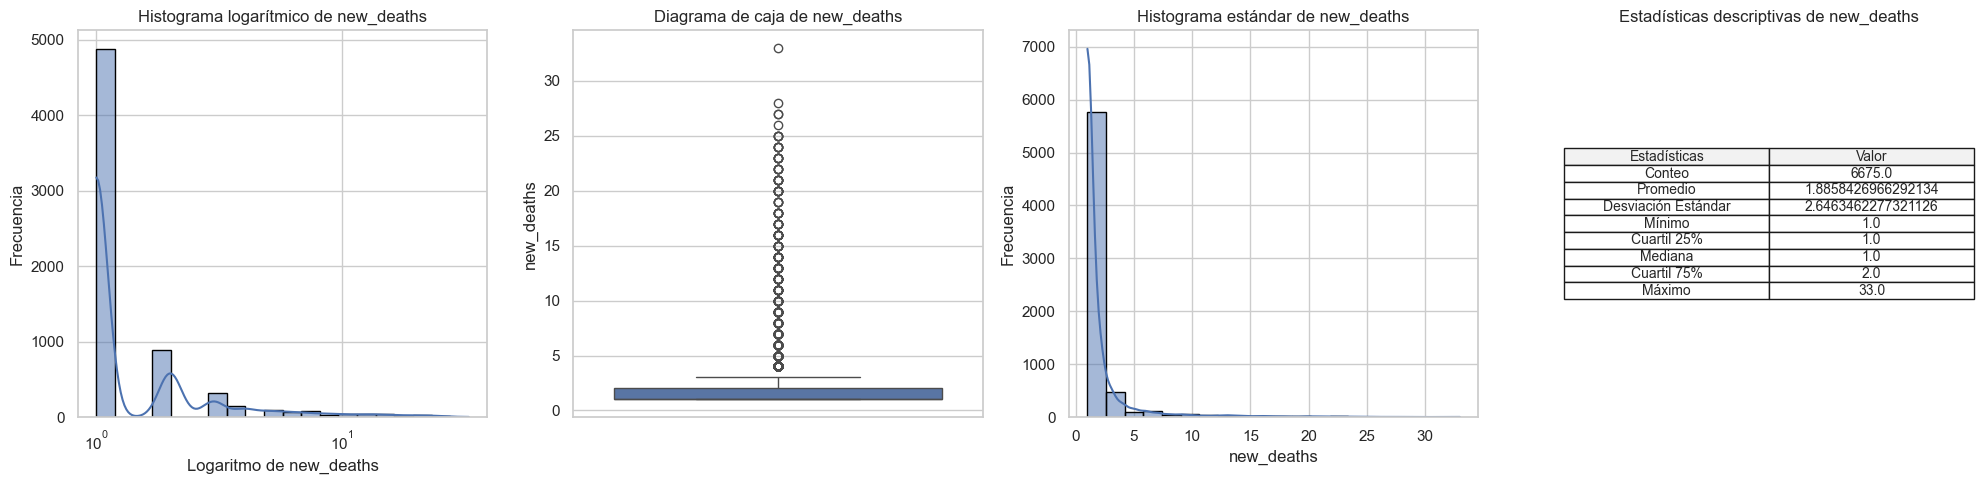

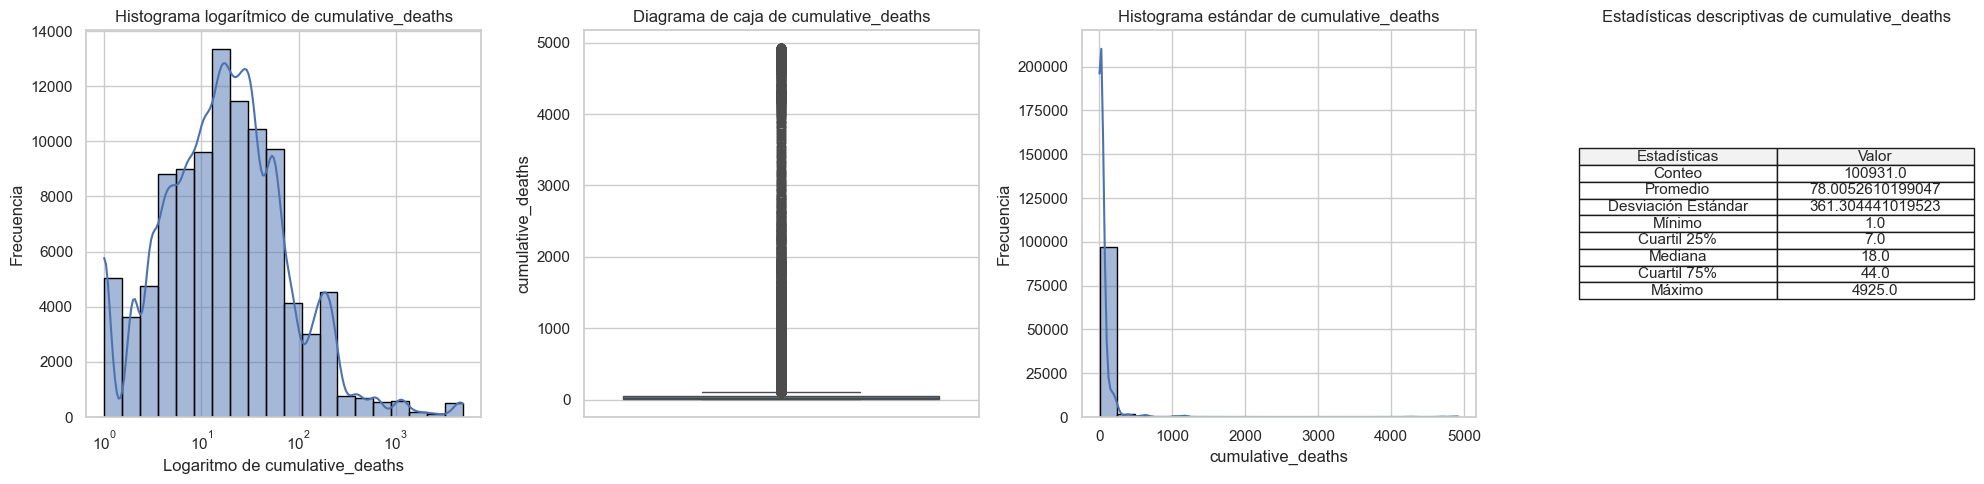

In [4]:

plot_analysis(df_municipality, 'population')
plot_analysis(df_mdp, 'new_deaths')
plot_analysis(df_mdp, 'cumulative_deaths')

### Datos Cualitativos

#### Funcion datos cualitativos

In [13]:
def generate_count_plot(data, x_column, x_label, y_label, title, size=False):
    """
    Genera un diagrama de barras para el conteo de registros.

    Parameters:
    - data: DataFrame que contiene los datos.
    - x_column: Nombre de la columna en el DataFrame para el eje x.
    - x_label: Etiqueta del eje x.
    - y_label: Etiqueta del eje y.
    - title: Título del diagrama.

    Returns:
    None (muestra el diagrama).
    """
    # Configurar el estilo de seaborn
    sns.set(style="whitegrid")

    # Crear un diagrama de barras
    figsize = (50, 6) if size else (15, 6)
    plt.figure(figsize=figsize)
    sns.countplot(data=data, x=x_column, order=data[x_column].value_counts().index)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.show()

#### Uso y calculo de registros por departamento y municipio

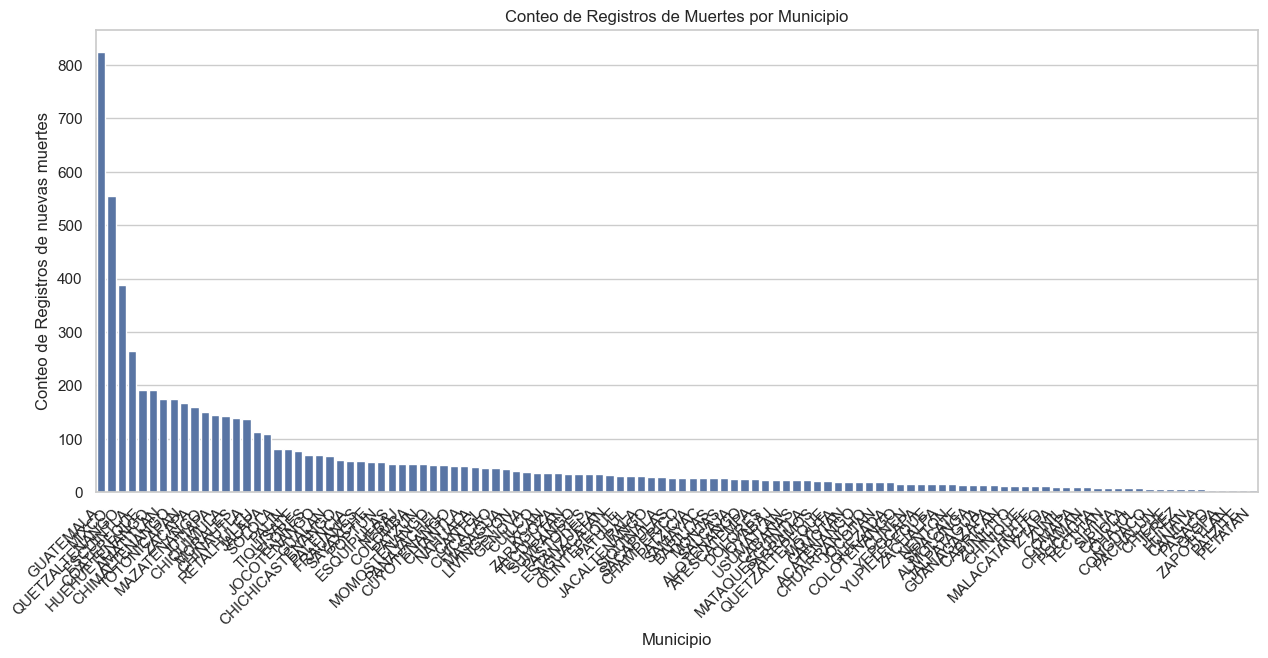

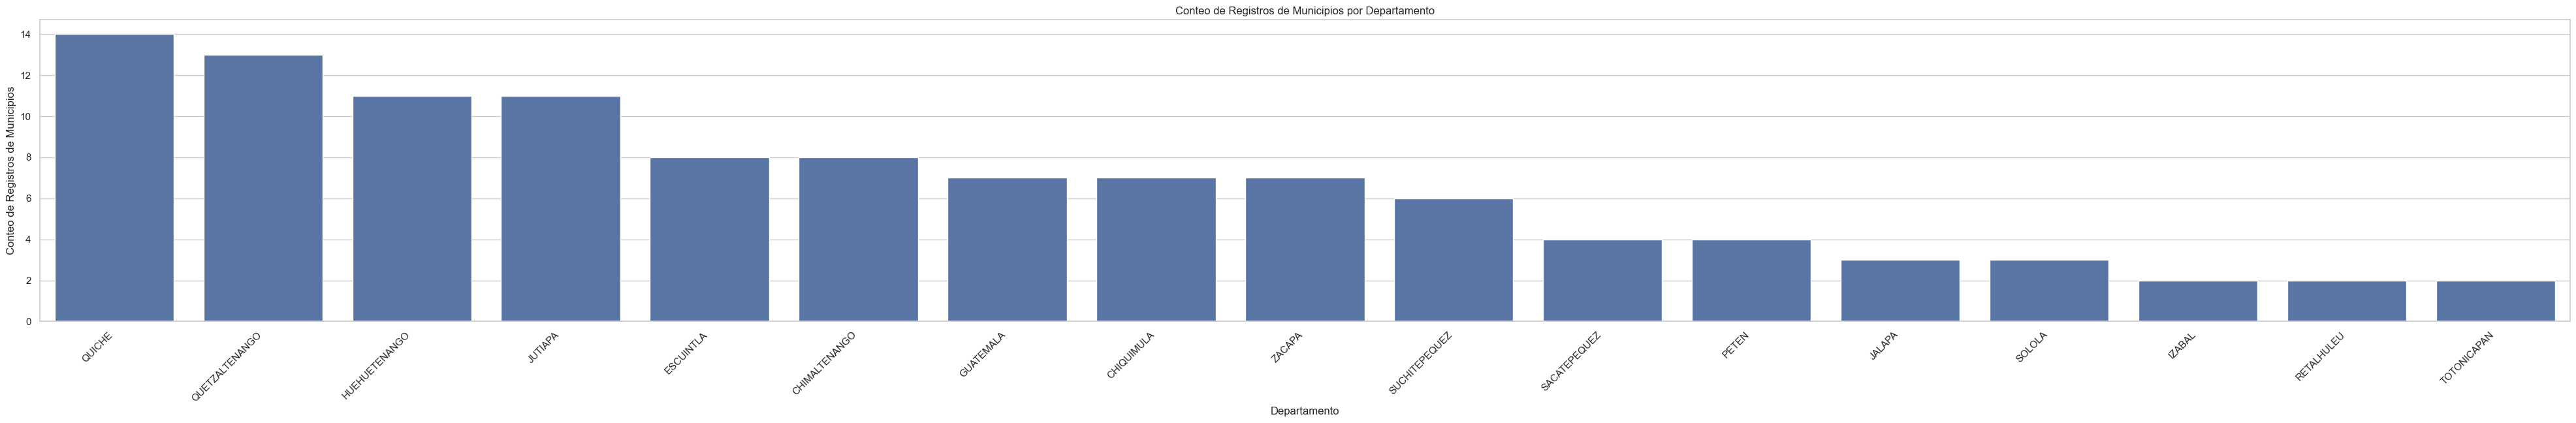

In [12]:
# Configurar el tamaño predeterminado de las figuras para evitar recortes
# plt.rcParams['figure.figsize'] = [15, 6]
# Configurar el scroll horizontal para las figuras grandes
# %matplotlib widget

# Generar diagrama de barras para municipios
generate_count_plot(df_mdp_gt_0, 'municipality', 'Municipio', 'Conteo de Registros de nuevas muertes', 'Conteo de Registros de Muertes por Municipio', True)

# Generar diagrama de barras para departamentos
generate_count_plot(df_municipality, 'name_department', 'Departamento', 'Conteo de Registros de Municipios', 'Conteo de Registros de Municipios por Departamento')

### Pruebas

In [188]:
# Unir el DataFrame de Municipality con el de Department
# df_merged = pd.merge(df_municipality, df_department, on='code_department', how='left')

# Unir el DataFrame de Municipality con el de MunicipalityDeathsReported
df_merged = pd.merge(df_municipality, df_mdp, on='code_municipality', how='left')

# Unir el DataFrame resultante con el de Cases
df_merged = pd.merge(df_merged, df_country_cases, on=['code_country', 'date_reported'], how='left')

# Seleccionar las columnas relevantes para el análisis cuantitativo
columns_of_interest = ['municipality', 'population', 'new_deaths_x', 'new_deaths_y', 'cumulative_deaths']
df_analysis = df_merged[columns_of_interest]

df_merged.head(5)

,code_municipality,municipality,population,code_department,name_department,code_country,name_country,date_reported,new_deaths_x,new_cases,cumulative_cases,new_deaths_y,cumulative_deaths
0,1001,MAZATENANGO,83448,10,SUCHITEPEQUEZ,GT,Guatemala,2020-03-15,0,1.0,1.0,0.0,0.0
1,1001,MAZATENANGO,83448,10,SUCHITEPEQUEZ,GT,Guatemala,2020-03-21,0,2.0,9.0,0.0,1.0
2,1001,MAZATENANGO,83448,10,SUCHITEPEQUEZ,GT,Guatemala,2020-04-04,0,3.0,50.0,0.0,1.0
3,1001,MAZATENANGO,83448,10,SUCHITEPEQUEZ,GT,Guatemala,2020-04-10,0,8.0,95.0,0.0,3.0
4,1001,MAZATENANGO,83448,10,SUCHITEPEQUEZ,GT,Guatemala,2020-04-11,0,31.0,126.0,0.0,3.0


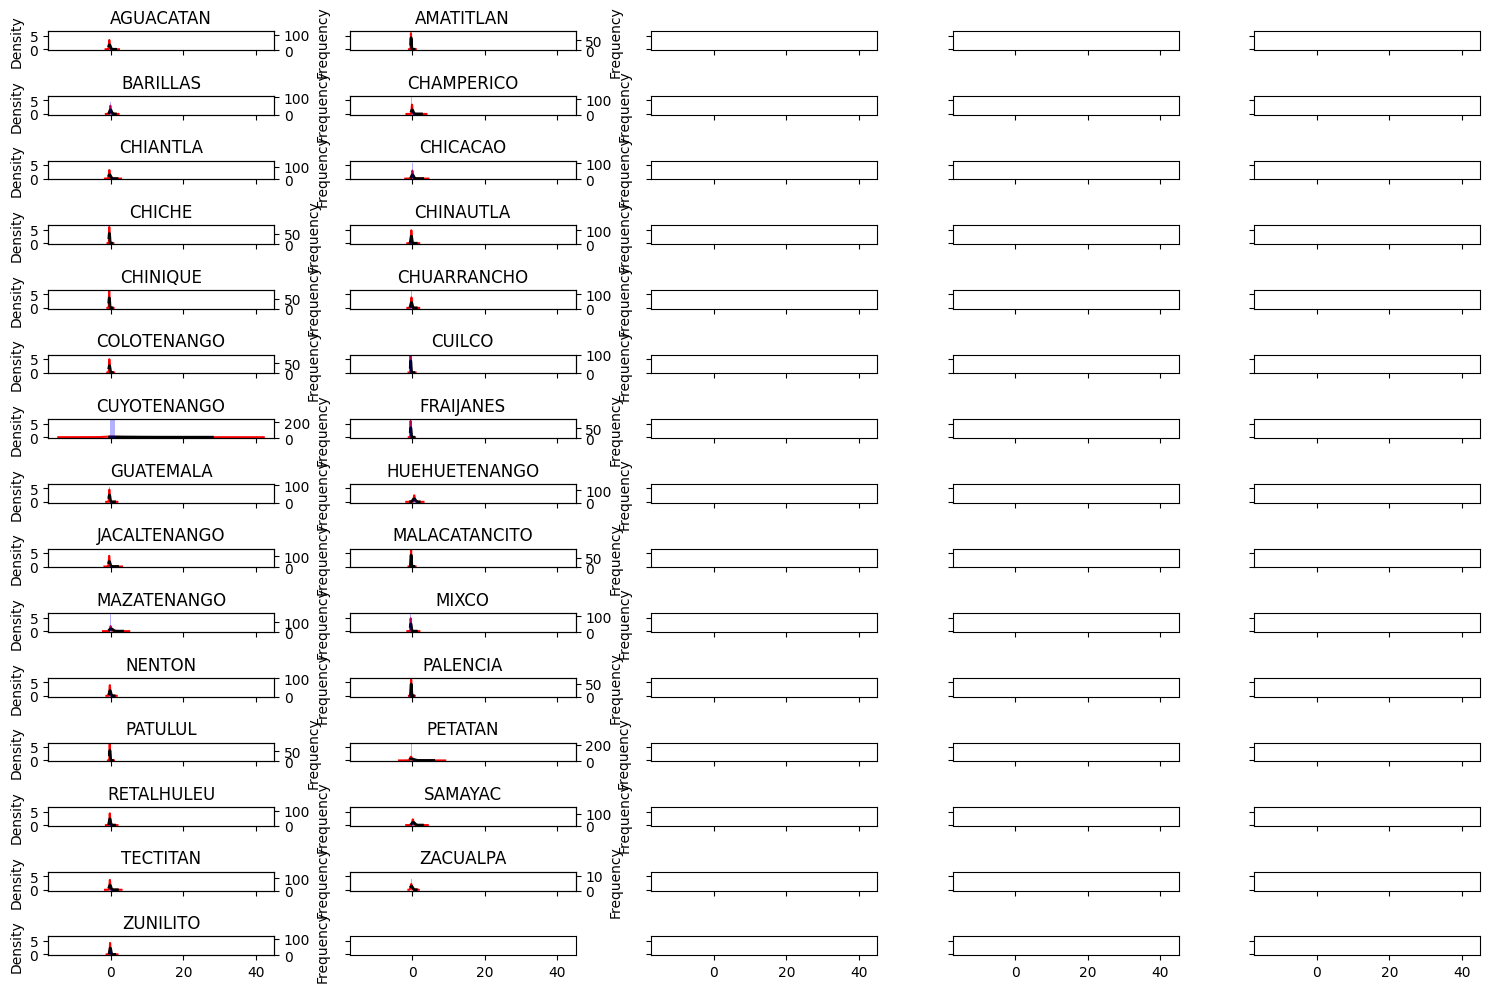

                PC1           PC2
count  2.825400e+04  2.825400e+04
mean   2.816620e-17 -2.414246e-17
std    1.289603e+00  1.038577e+00
min   -5.472557e-01 -2.274950e+00
25%   -3.701611e-01 -4.447241e-01
50%   -2.512872e-01  1.720839e-01
75%   -1.879646e-02  6.467796e-01
max    2.801472e+01  2.852567e+00


In [189]:
# Eliminar duplicados
df_analysis = df_analysis.drop_duplicates()

# Seleccionar las columnas de interés
columns_of_interest = ['municipality', 'population', 'new_deaths_x', 'new_deaths_y', 'cumulative_deaths']
df_analysis = df_analysis[columns_of_interest]

# Imputar valores faltantes (en este caso, usando el valor medio)
imputer = SimpleImputer(strategy='mean')
df_analysis_imputed = pd.DataFrame(imputer.fit_transform(df_analysis.drop('municipality', axis=1)), columns=df_analysis.columns[1:])

# Estandarizar los datos para PCA
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_analysis_imputed)

# Aplicar PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_standardized)

# Añadir las columnas de municipio y componentes principales al DataFrame
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
df_pca['municipality'] = df_analysis['municipality']

# Mostrar estadísticos descriptivos para componentes principales
statistics_pca = df_pca.describe()

# Mostrar histogramas con kde y distribución normal para componentes principales
g = df_pca.groupby('municipality')
n = g.ngroups
fig, axes = plt.subplots(n // 2 + n % 2, 2, figsize=(15, 10), sharex=True, sharey=True)

for i, (name, group) in enumerate(g):
    r, c = i // 2, i % 2
    a1 = axes[r, c]
    a2 = a1.twinx()

    # Histograma
    group['PC1'].plot.hist(ax=a2, alpha=0.3, bins=20, color='blue')

    # KDE
    group['PC1'].plot.kde(title=name, ax=a1, c='r')

    # Ajustar una distribución normal
    mu, std = group['PC1'].mean(), group['PC1'].std()
    x = np.linspace(group['PC1'].min(), group['PC1'].max(), 100)
    p = norm.pdf(x, mu, std)
    a1.plot(x, p, 'k', linewidth=2)

fig.tight_layout()
plt.show()

# Mostrar estadísticos descriptivos para componentes principales
print(statistics_pca)

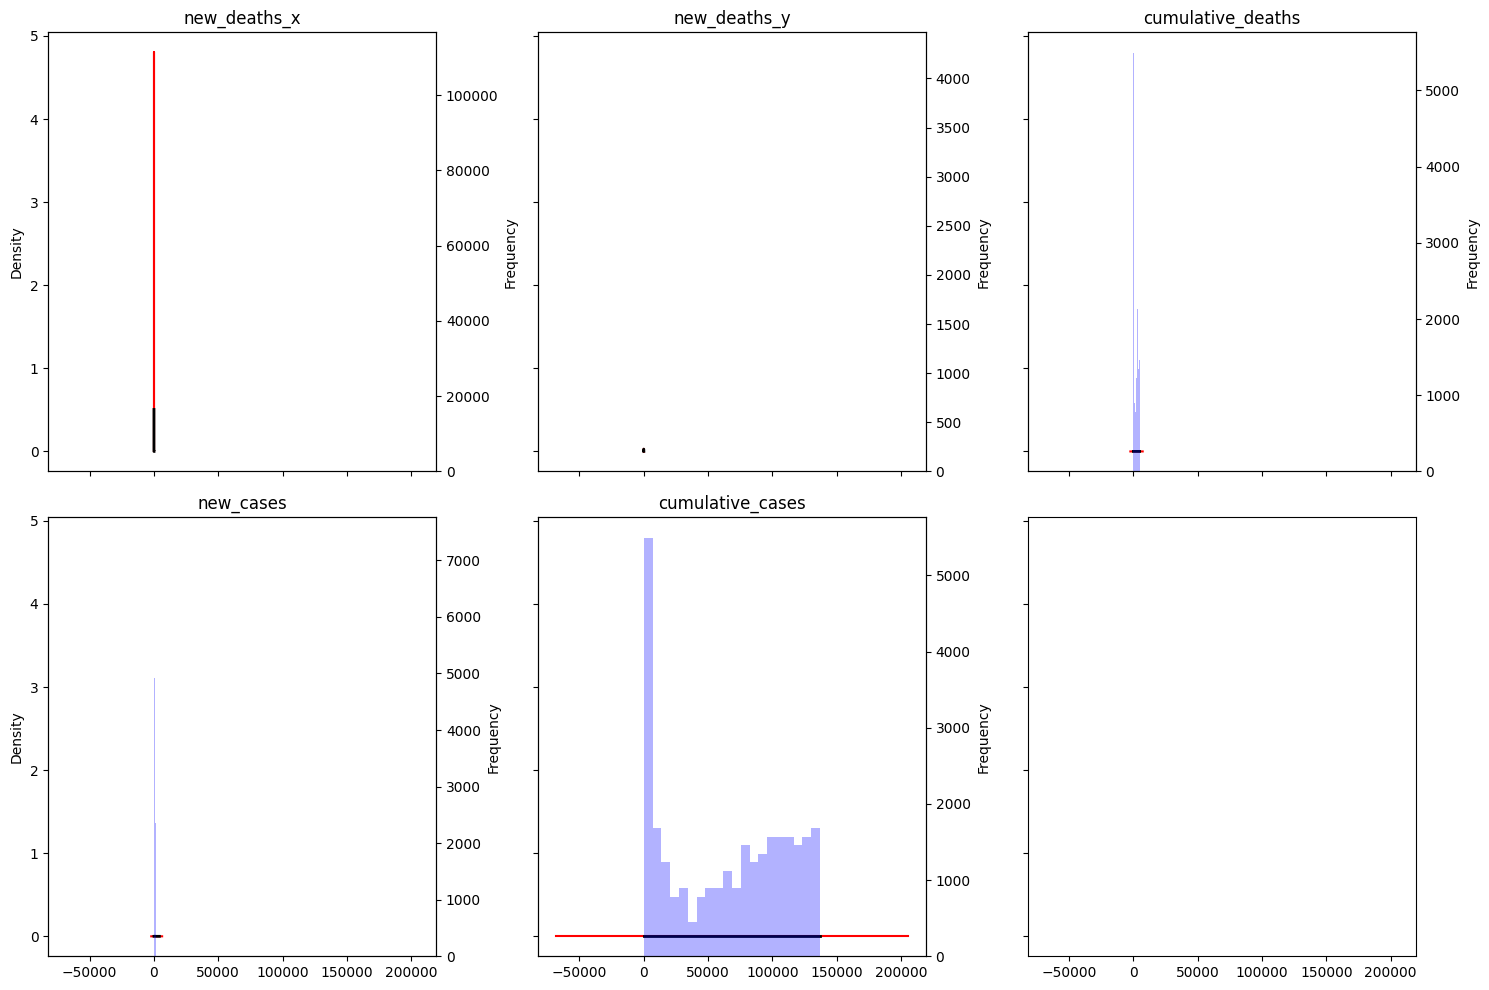

                PC1           PC2    population
count  1.128960e+05  1.128960e+05  1.128960e+05
mean   4.921737e-17 -7.451837e-17  6.745479e+04
std    1.452926e+00  1.260961e+00  1.233845e+05
min   -4.693645e+00 -1.283179e+00  6.706000e+03
25%   -1.162348e-03 -3.766050e-01  1.975675e+04
50%   -8.182730e-04 -2.395943e-01  4.216300e+04
75%    5.058305e-05  3.719053e-02  7.327250e+04
max    5.068098e+00  3.572699e+01  1.205668e+06


In [ ]:
# Mostrar estadísticos descriptivos
# Eliminar duplicados
df_analysis = df_analysis.drop_duplicates()

# Seleccionar las columnas de interés
columns_of_interest = ['municipality', 'population', 'new_deaths_x', 'new_deaths_y', 'cumulative_deaths']
# columns_of_interest = ['municipality', 'population', 'new_deaths']
df_analysis = df_analysis[columns_of_interest]

# Estandarizar los datos para PCA
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_analysis.drop('municipality', axis=1))

# Aplicar PCA
pca = PCA(n_components=2)  # Puedes ajustar el número de componentes según sea necesario
df_pca = pca.fit_transform(df_standardized)

# Añadir las columnas de municipio y componentes principales al DataFrame
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
df_pca['municipality'] = df_analysis['municipality']

# Mostrar estadísticos descriptivos para componentes principales
statistics_pca = df_pca.describe()

# Mostrar histogramas con kde y distribución normal para componentes principales
g = df_pca.groupby('municipality')
n = g.ngroups
fig, axes = plt.subplots(n // 2, 2, figsize=(15, 10), sharex=True, sharey=True)

for i, (name, group) in enumerate(g):
    r, c = i // 2, i % 2
    a1 = axes[r, c]
    a2 = a1.twinx()

    # Histograma
    group['PC1'].plot.hist(ax=a2, alpha=0.3, bins=20, color='blue')

    # KDE
    group['PC1'].plot.kde(title=name, ax=a1, c='r')

    # Ajustar una distribución normal
    mu, std = group['PC1'].mean(), group['PC1'].std()
    x = np.linspace(group['PC1'].min(), group['PC1'].max(), 100)
    p = norm.pdf(x, mu, std)
    a1.plot(x, p, 'k', linewidth=2)

fig.tight_layout()
plt.show()

# Mostrar estadísticos descriptivos para componentes principales
print(statistics_pca)

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values